# Clustering analysis of seagrass environmental conditions

**Aim:** To identify any clusters within the environmental conditions of Zostera marina seagrass beds (e.g. temperature, exposure, turbidity, local soil type etc). This doesn't include the carbon data associated with the seagrass beds in the dataset.

In [1]:
import numpy as np
import pacmap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [4]:
from sklearn.manifold import TSNE

## 1. Import Full Dataset

In [5]:
## Import carbon data
path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1E_Final dataset\Outputs\final_dataset.csv"
df = pd.read_csv(path, index_col = 0)

** ID_225 missing tidal range value - amend later

In [6]:
df[df.index == 'ID_225']

,Site_name,Lat,Long,Cstock25_Mgha,C25_SD,Species,Mono_mix,exposure,extr_exposure,ECO_CODE,...,PAR_mean,PAR_std,MEAN_SIG_WAVEHEIGHT,TEMP_MOISTURE,EMU_PHYSICAL,REGIONAL_SINUOSITY,GHM,MAX_SLOPE,OUTFLOW_DENSITY,ERODIBILITY
ID_225,Neill Point (50.2),47.334,-122.491,13.94,NaN,Z. marina,Monospecific,7256.59,12586.72,25056.0,...,64.365327,2.112282,0.114786,Cool Temperate Moist,Euhaline-Oxic-Moderate,1.7154,0.413045,39.04253,48661.17578,High


## 2. Dataset pre-processing

Tidy up dataset - remove nans - encode object columns for clustering

In [7]:
#drop rows with nan in long/lat column (to remove those with no data)
df = df[df['Lat'].notna()]

In [8]:
#rename to combine Z.marina mixed to one name
df['Species'].replace({'Z. marina/Z. angustifolia/Z. noltii/Ruppiaspp.': 'Z. marina mixed', 'Z. marina/Z. noltii': 'Z. marina mixed'}, inplace = True)
df['Species'].unique()

array(['Z. marina', 'unvegetated', 'Z. japonica', 'Z. marina mixed',
       'Z. angustifolia/Z. noltii', 'Z. angustifolia', 'Z. notlii'],
      dtype=object)

In [9]:
df['Species'][df['Species'] == 'Z. marina'].count()

169

### Encode object data

In [10]:
#one hot encode object types
from sklearn.preprocessing import OneHotEncoder

#species  #don't encode as only going to use Z.marina
df_all = df.copy()
#df_species = pd.get_dummies(df_all["Species"]) #encode species column
#df_all = pd.concat([df_all, df_species.set_index(df_all.index)], axis = 1)

#temp_moisture  ##leave out for now as duplicate climate variables
df_tm = pd.get_dummies(df_all["TEMP_MOISTURE"])
df_all = pd.concat([df_all, df_tm.set_index(df_all.index)], axis = 1)

#emu_physical = leave out for now = duplicate of climate variables?
df_emu = pd.get_dummies(df_all["EMU_PHYSICAL"])
df_all = pd.concat([df_all, df_emu.set_index(df_all.index)], axis = 1)

#ECOREGION
df_eco = pd.get_dummies(df_all['PROVINCE'])
df_all = pd.concat([df_all, df_eco.set_index(df_all.index)], axis =1)

#erodibility
df_erod = pd.get_dummies(df_all['ERODIBILITY'], prefix = 'Erod')
df_all = pd.concat([df_all, df_erod.set_index(df_all.index)], axis = 1)

df_all.shape

(237, 103)

**QU** - Is this the best way to encode objects?

In [11]:
df_eco

,Black Sea,Cold Temperate Northeast Pacific,Cold Temperate Northwest Atlantic,Cold Temperate Northwest Pacific,Lusitanian,Mediterranean Sea,Northern European Seas,Warm Temperate Northeast Pacific,Warm Temperate Northwest Pacific
ID_101,0,1,0,0,0,0,0,0,0
ID_102,0,1,0,0,0,0,0,0,0
ID_103,0,1,0,0,0,0,0,0,0
ID_104,0,1,0,0,0,0,0,0,0
ID_105,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
ID_341,0,0,0,0,0,0,1,0,0
ID_342,0,0,0,0,0,0,1,0,0
ID_343,0,0,0,0,0,0,1,0,0
ID_344,0,0,0,0,0,0,1,0,0


In [12]:
df_all.Species[df.Species == 'Z. marina'].count()

169

In [13]:
df_all.shape

(237, 103)

### Create cluster dataframe with only columns of interest

In [14]:
#Select only rows that are Z. marina or Z. marina mixed
zmarina = ['Z. marina', 'Z. marina mixed']
df_zmarina = df_all[df_all['Species'].isin(zmarina)]

### Make all numeric

In [15]:
#select numeric only
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
df_num = df_zmarina.select_dtypes(include=numerics)

#log large part of dataframe - #don't log as normalising later
# log_cols = ['exposure', 'extr_exposure','mean_area_chl_oc3', 'mean_area_chl_re_gons',
#        'mean_area_TUR_Nechad2016_665', 'mean_area_SPM_Nechad2016_665',
#        'mean_area_p3qaa_zSD', 
#        'mean_area_p3qaa_eta',]
# df_cluster[log_cols] = df_cluster[log_cols].apply(np.log10)

df_num.keys()

Index(['Lat', 'Long', 'Cstock25_Mgha', 'C25_SD', 'exposure', 'extr_exposure',
       'ECO_CODE', 'PROV_CODE', 'RLM_CODE', 'NEAR_DIST', 'range_chl_oc3',
       'range_chl_re_gons', 'range_TUR_Nechad2016_665',
       'range_SPM_Nechad2016_665', 'range_p3qaa_zSD', 'range_p3qaa_zSD_biased',
       'range_p3qaa_eta', 'range_p3qaa_KPAR', 'mean_area_chl_oc3',
       'mean_area_chl_re_gons', 'mean_area_TUR_Nechad2016_665',
       'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD',
       'mean_area_p3qaa_zSD_biased', 'mean_area_p3qaa_eta',
       'mean_area_p3qaa_KPAR', 'sum_area_chl_oc3', 'sum_area_chl_re_gons',
       'sum_area_TUR_Nechad2016_665', 'sum_area_SPM_Nechad2016_665',
       'sum_area_p3qaa_zSD', 'sum_area_p3qaa_zSD_biased', 'sum_area_p3qaa_eta',
       'sum_area_p3qaa_KPAR', 'mean_pressure', 'var_mean_pressure',
       'std_mean_pressure', 'mean_temp', 'var_mean_temp', 'std_mean_temp',
       'mean_rain', 'var_mean_rain', 'std_mean_rain', 'Tidal_range',
       'SUB_AREA', 'soi

In [16]:
#select only columns that want to cluster on
cluster_cols = ['Lat', 'exposure', 'extr_exposure', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665',
       'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD', 'mean_area_p3qaa_eta', 'mean_pressure', 'mean_temp',
        'soil_clay%', 'soil_erosion', 
       'soil_silt%', 'soil_sand%', 'soil_carbon_stock', 'PAR_mean', 'forest%', 'MEAN_SIG_WAVEHEIGHT', 
        'REGIONAL_SINUOSITY', 'GHM', 
       'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 
       'Erod_High', 'Erod_Low', 'Erod_Medium', 'Erod_Non']

all_cols = df_num.drop(['Cstock25_Mgha', 'C25_SD', 'ECO_CODE', 'PROV_CODE',
       'RLM_CODE'], axis = 1)

#df_cluster = df_num.loc[:, cluster_cols]

df_cluster = all_cols.copy()

#all_cols.keys()
#df_cluster.shape

In [17]:
#remove nans from final df_cluster
df_cluster = df_cluster.dropna(how='any')
df_cluster.shape

(179, 89)

In [18]:
check_for_nan = df_cluster[df_cluster.isna().any(axis =1)]
check_for_nan

,Lat,Long,exposure,extr_exposure,NEAR_DIST,range_chl_oc3,range_chl_re_gons,range_TUR_Nechad2016_665,range_SPM_Nechad2016_665,range_p3qaa_zSD,...,Cold Temperate Northwest Pacific,Lusitanian,Mediterranean Sea,Northern European Seas,Warm Temperate Northeast Pacific,Warm Temperate Northwest Pacific,Erod_High,Erod_Low,Erod_Medium,Erod_Non


### Finalise dataframes 

Dataframes:
1. **names**: label data to compare clusters to
2. **df_cluster**: numerical dataset ready for clustering

In [19]:
names = df_all.loc[:, ['Site_name', 'ECOREGION', 'Species', 'PROVINCE', 'Cstock25_Mgha']]
#names = names[names.isna().any(axis = 1)]
names = names[names.index.isin(df_cluster.index)]  #select only rows that match df_cluster index
names
names.shape

(179, 5)

In [20]:
#check length is the same
df_cluster.shape

(179, 89)

## 3. Normalise data

Visualise shape of data first to identify features that may need log. Log features then standardise whole dataset

In [21]:
X = df_cluster.copy()

In [22]:
# X_melt = pd.melt(X)
# g= sns.FacetGrid(X_melt, col = 'variable', sharex = False, col_wrap = 6)
# g.map(sns.histplot, 'value', alpha = 0.7)

In [23]:
# perform a yeo-johnson transform of the dataset
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X)

#Standardise before power transform
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_pt)

#convert back to dataframe with column names and call X_norm for following code
X_norm = pd.DataFrame(X_std, columns = X.columns)

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


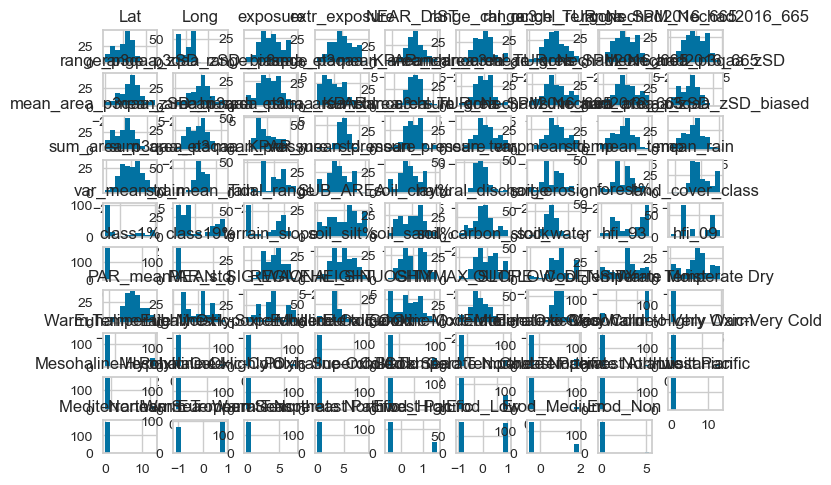

In [24]:
#check distributions of standardised data
X_norm.hist();

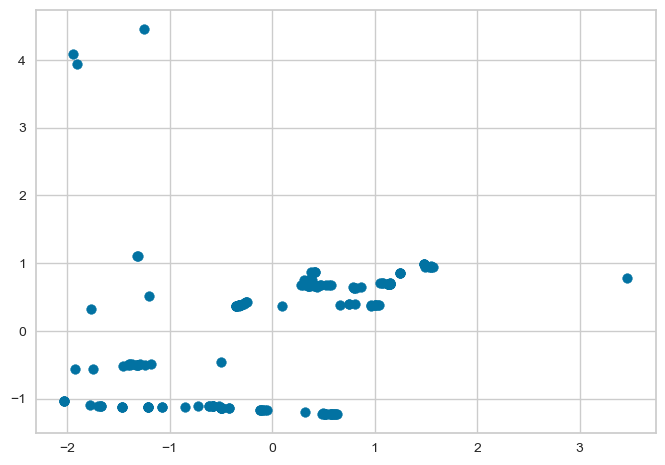

In [25]:
X_array = np.asarray(X_norm)
plt.scatter(X_array[:, 0], X_array[:, 1])
plt.show()

In [26]:
#viz distributions of features 
# X_short = X.loc[:, ['exposure', 'extr_exposure', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665',
#        'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD']]
# X_short_log = np.log10(X_short)
# X_short_log_norm =scaler.fit_transform(X_short_log)
# X_short_log_norm = pd.DataFrame(X_short_log_norm, columns = X_short.columns)
# sns.pairplot(X_short_log_norm)

## 4. Determine best number of clusters for KMeans

In [27]:
# define max. 6 different cluster colors
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252', '#6a040f']

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

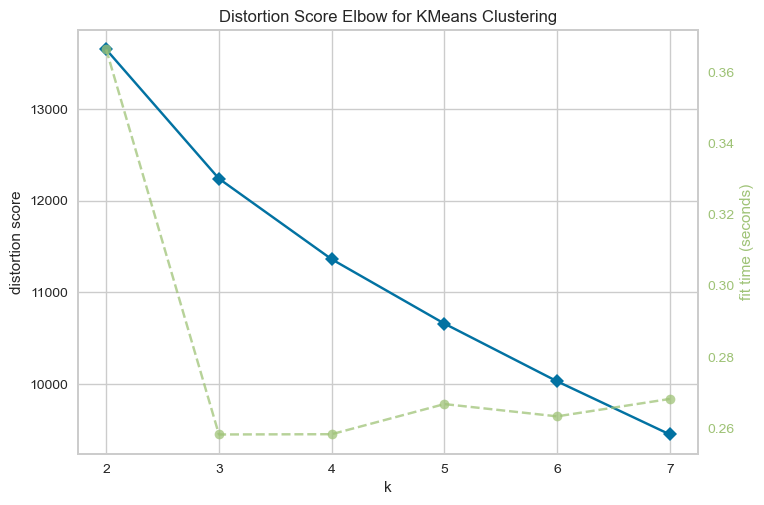

In [29]:
# plot elbow plot to determine number of clusters
fig, ax = plt.subplots()
visualizer = KElbowVisualizer(KMeans(n_init = 10), k = (2,8), ax = ax)
visualizer.fit(X_norm)
ax.set_xticks(range(2,8))
visualizer.show()
plt.show()

**QU** How do I resolve the above warning?

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

([<matplotlib.axis.XTick at 0x215098b1750>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

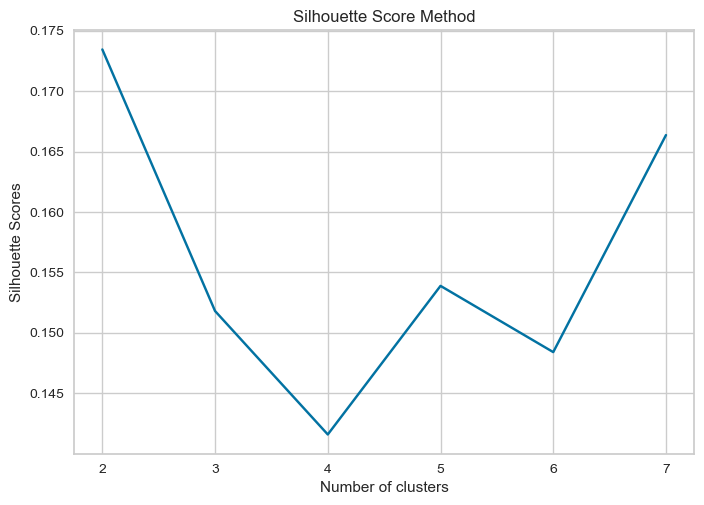

In [30]:
# Silhouette Score Method
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42,
                algorithm = 'lloyd')
    km.fit(X_norm)
    silhouette_scores.append(silhouette_score(X_norm, km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 8), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 8))

Does this show the higher the silhoutte score the better? Suggesting 4 clusters?

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

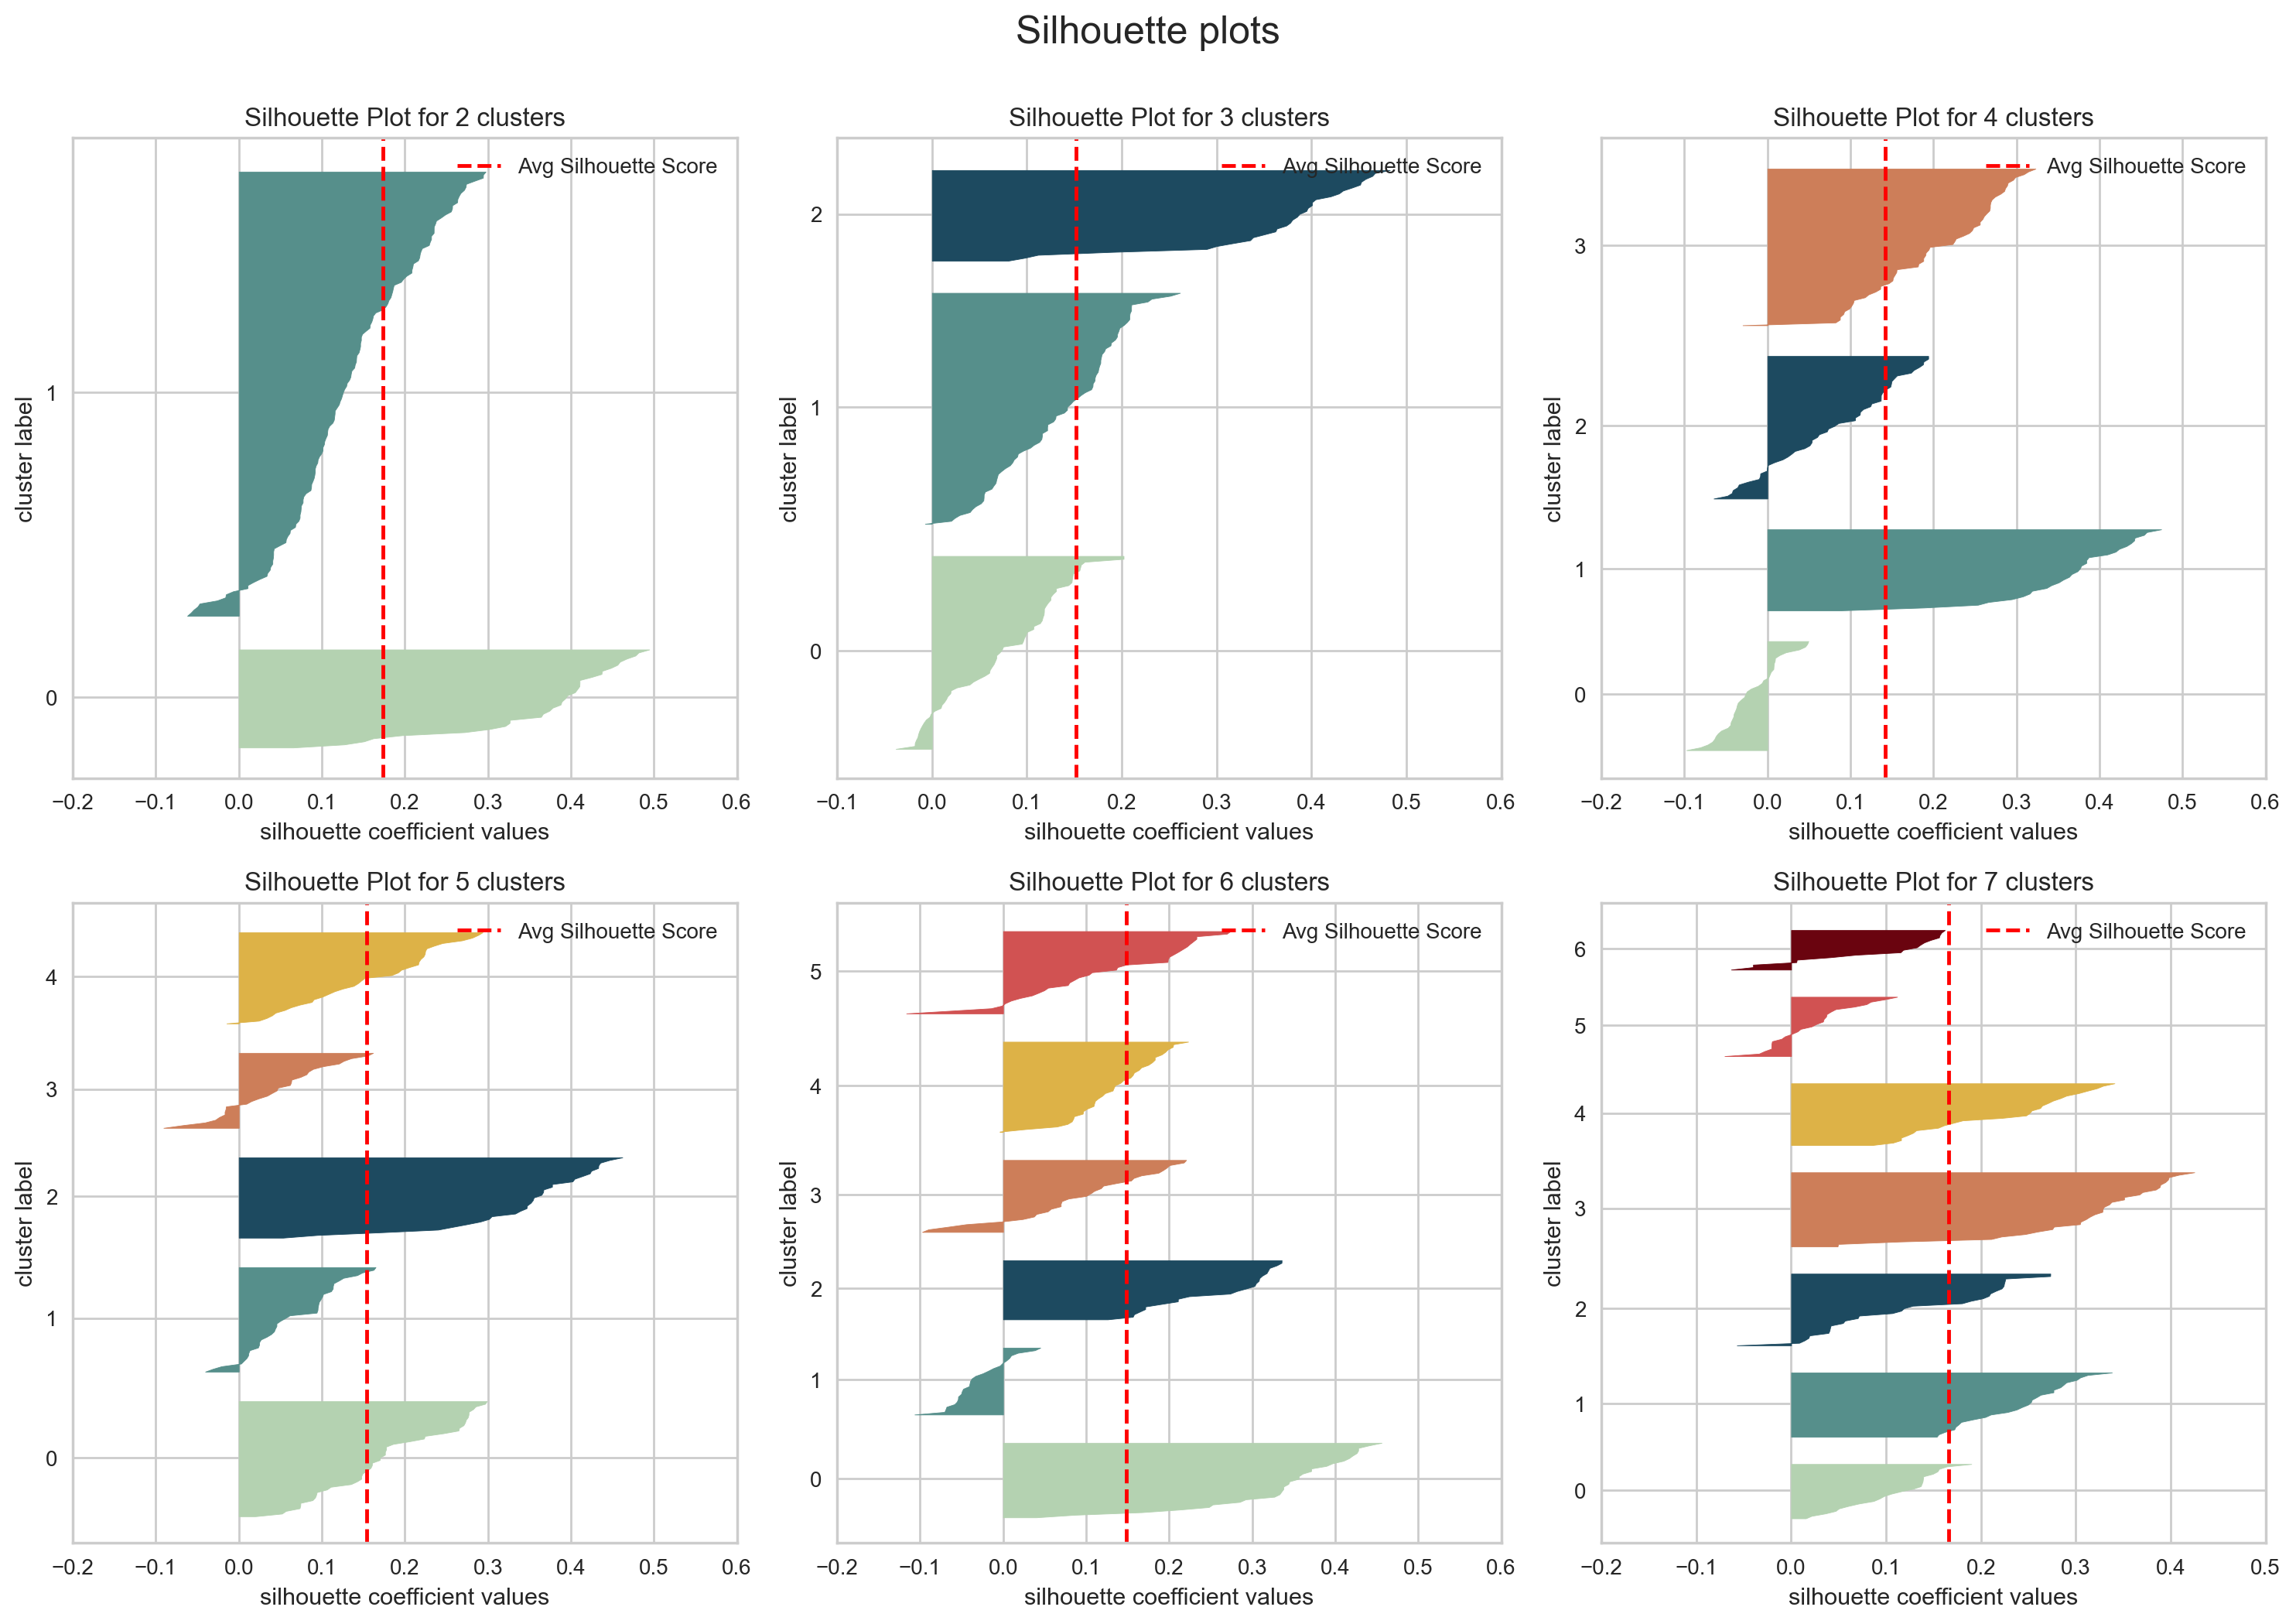

In [31]:
# Run silhouette analysis
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker

def silhouette_plot(X, model, ax, colors):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values,
                         facecolor=colors[idx],edgecolor=colors[idx]
        )
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax


# Plot for multiple ks
k_max = 7
ncols = 3
# calculate number of rows
nrows = k_max // ncols + (k_max % ncols > 0)
# set figure size
fig = plt.figure(figsize=(15,15), dpi=200)

for k in range(2,k_max+1):
    
    # Apply clustering for k clusters
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')

    km_fit = km.fit(X_norm)
    
    # create chart
    ax = plt.subplot(nrows, ncols, k-1)
    silhouette_plot(X_norm, km_fit, ax, cluster_colors)

fig.suptitle("Silhouette plots", fontsize=18, y=1)
plt.tight_layout()
plt.show()

How to interpret silhoutte analysis? See: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Sihouette coefficients near +1 are far away from neighbouring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary. Don't want any that go into -ve values as assigned to wrong cluster. Also the thickness of the sihouette plot - bigger may be as grouping of sub-clusters into one big cluster. Similar thickness, similar sized clusters.

3 clusters looks best here

## 4a: DBSCAN 

In [33]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.3, min_samples = 10).fit(X_norm)
labels = db.labels_

In [34]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 179


In [35]:
#print(f"Silhouette Coefficient: {metrics.silhouette_score(X_norm, labels):.3f}")

## 4b. KMeans

In [36]:
#final decision - build clusters based on 3
km = KMeans(n_clusters=2, 
            max_iter=300, #max number of iterations for a single run
            tol=1e-04, #relative tolerance
            init='k-means++', #selects initial cluster centroids using sampling based on an empirical probability distribution of the points contribution to the overall inertia
            n_init=10, #the number of runs with different centroid seeds
            random_state=42, 
            algorithm='lloyd')

km_fit = km.fit(X_norm)

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [37]:
labels = km_fit.labels_

## 5. Cluster Diagnoses

##### Diagnose our clusters in terms of their magnitude and cardinality
See: https://towardsdatascience.com/common-mistakes-in-cluster-analysis-and-how-to-avoid-them-eb960116d773

In [38]:
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality

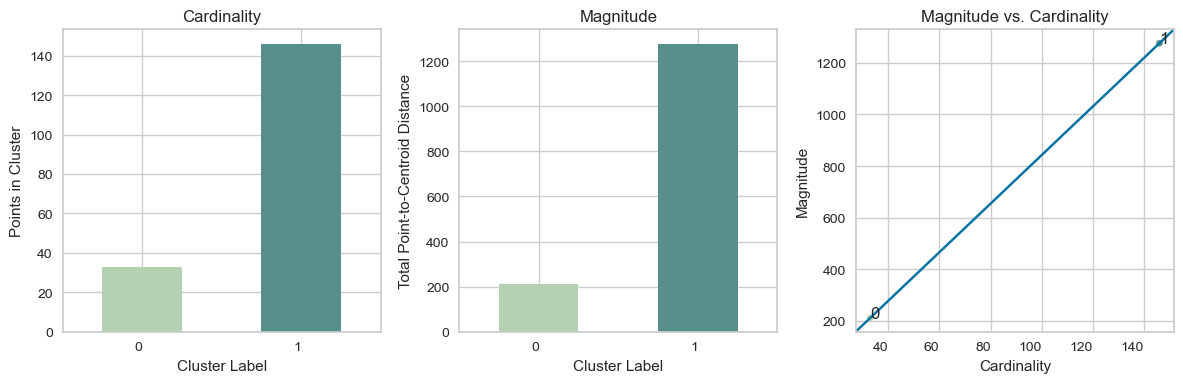

In [39]:
from scipy.spatial.distance import euclidean

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

plot_cluster_cardinality(km_fit.labels_,
                         ax=ax1,
                         title="Cardinality",
                         color=cluster_colors
                        )
plot_cluster_magnitude(X_norm,
                       km_fit.labels_,
                       km_fit.cluster_centers_,
                       euclidean,
                       ax=ax2,
                       title="Magnitude",
                       color=cluster_colors
                      )
plot_magnitude_vs_cardinality(X_norm, km_fit.labels_,
                              km_fit.cluster_centers_,
                              euclidean,
                              color=cluster_colors[0:km_fit.n_clusters],
                              ax=ax3, 
                              title="Magnitude vs. Cardinality"
                             )

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

Cluster cardinality is the number of examples per cluster. Investigate clusters that are major outliers.  *Check cluster label 1. Cluster magnitude is the sum of distances from all examples to the centroid of the cluster. *Check cluster label 1. Magnitude vs cardinality: higher cluster cardinality tends to result in higher cluster magnitude. Clusters are anomalous when cardinality doesn't correlate with magnitude relative to the other clusters.

## 6. Visualising PCA and PaCMAP

Below plot doesn't work where I am passing in y==l in the ax.scatter - any ideas how to correct so it plots the arrays for the cluster?  Alternative plot below

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\pacmap\pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


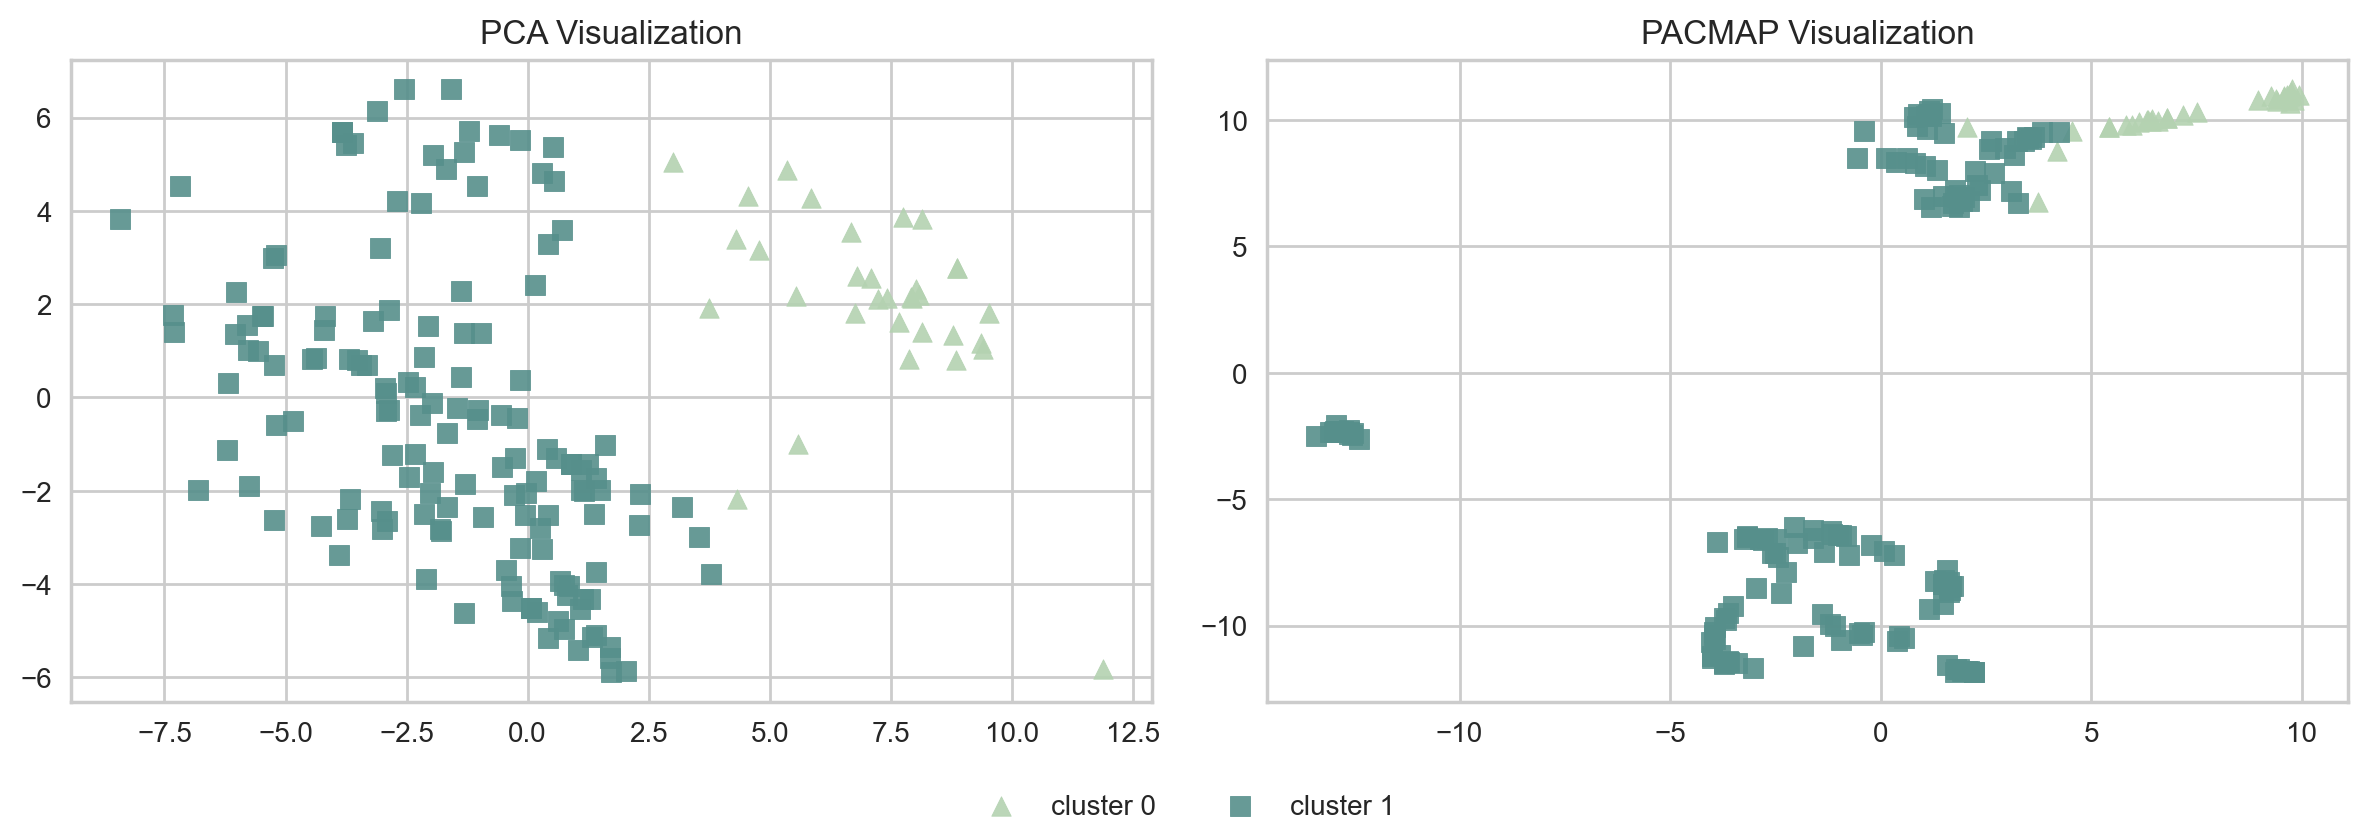

In [40]:
# Visualizing pca and pacmap
from sklearn.decomposition import PCA
import pacmap

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

# PCA
pca_scaled_std = PCA(n_components=2,random_state=42)

X_std_pca = pca_scaled_std.fit_transform(X_norm)
y = km_fit.labels_

for l, c, m in zip(range(0, km_fit.n_clusters), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o', '8', 'P', '*', 'D')):
    ax1.scatter(X_std_pca[y==l, 0],
                X_std_pca[y==l, 1],
                color=c,
                label='cluster %s' % l,
                alpha=0.9,
                marker=m
                )

# PACMAP
embedding = pacmap.PaCMAP(random_state=42)
#X_std_pacmap = embedding.fit_transform(X_norm.to_numpy())
X_std_pacmap = embedding.fit_transform(X_norm)  #already a numpy array

for l, c, m in zip(range(0, km_fit.n_clusters), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o', '8', 'P', '*', 'D')):
    
    ax2.scatter(X_std_pacmap[y==l, 0],
                X_std_pacmap[y==l, 1],
                color=c,
                label='cluster %s' % l,
                alpha=0.9,
                marker=m
                )
    
ax1.set_title("PCA Visualization")
ax2.set_title("PACMAP Visualization")

labels = np.unique(km_fit.labels_)
labels = ["cluster "+str(l) for l in labels]
fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
plt.tight_layout()
plt.show()

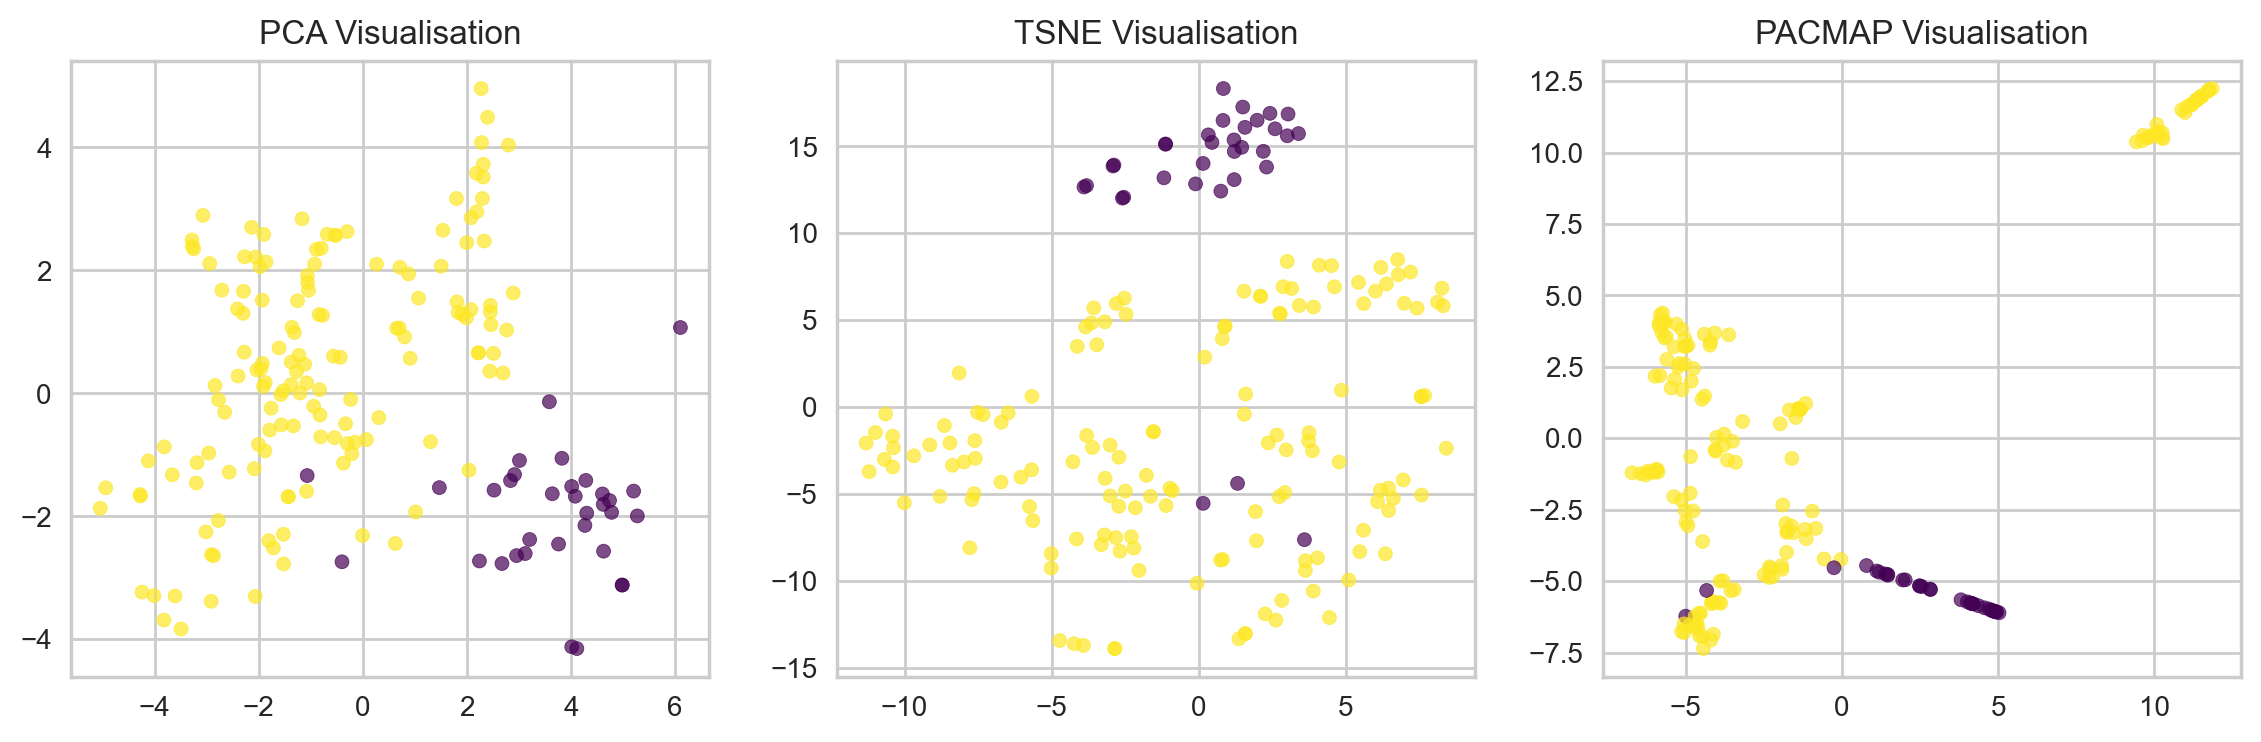

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4), dpi=200)
#set labels
l = km_fit.labels_

# PCA
pca_scaled_std = PCA(n_components=2,random_state=42)
X_std_pca = pca_scaled_std.fit_transform(X_norm)

ax1.scatter(x = X_std_pca[:,0], y = X_std_pca[:,1], cmap='viridis', c=l, s= 25, alpha = 0.7)
ax1.set_title('PCA Visualisation')

#t-SNE
tsne = TSNE(learning_rate = 150)
X_tsne = tsne.fit_transform(X_norm)
ax2.scatter(x = X_tsne[:,0], y = X_tsne[:,1], cmap = 'viridis', c = l, s = 25, alpha = 0.7)
ax2.set_title('TSNE Visualisation')

#PACMAP
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(X_norm, init="pca")

#plot
ax3.scatter(x = X_transformed[:, 0], y = X_transformed[:, 1], cmap="viridis", c=l, s=25, alpha =0.7)
ax3.set_title('PACMAP Visualisation');

## 6b. PACMAP Viz by Features

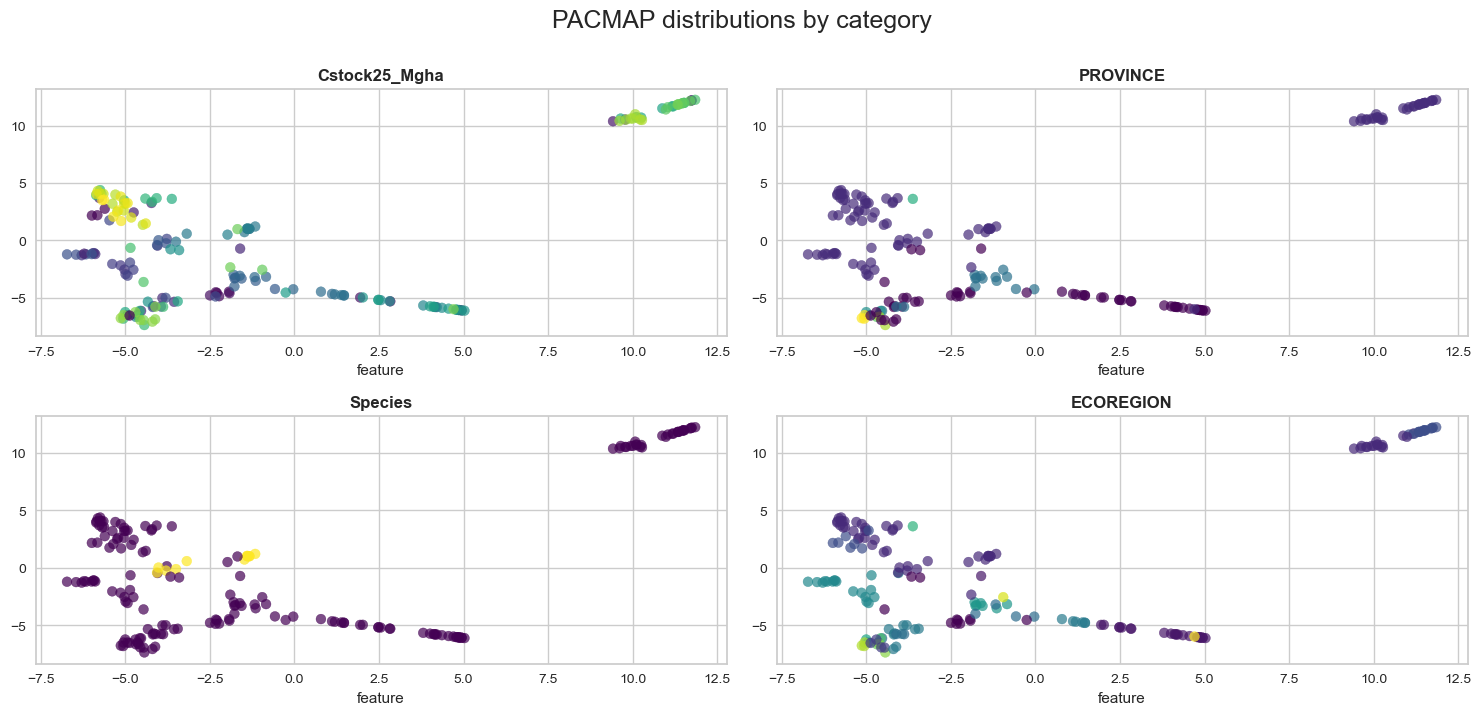

In [90]:
#X_transformed['carbon'] = names['Cstock25_Mgha']]

ncols = 2
nrows = len(names.columns)  // ncols + (len(names.columns)  % ncols > 0)
fig = plt.figure(figsize=(15,10))

names_r = names.iloc[:, ::-1]

for n, feature in enumerate(names_r):
    
    if feature != 'Site_name':
        pass
    #print(names[feature])
        ax = plt.subplot(nrows, ncols, n + 1)
        p = plt.scatter(x = X_transformed[:, 0], y = X_transformed[:, 1], cmap="viridis", c=pd.factorize(names_r[feature])[0], s=50, alpha =0.7)
        ax.set_xlabel('feature')
        ax.set_title(feature,fontweight="bold") 
        #ax.legend()

fig.suptitle('PACMAP distributions by category', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

In [60]:
X_norm.keys()

Index(['Lat', 'Long', 'exposure', 'extr_exposure', 'NEAR_DIST',
       'range_chl_oc3', 'range_chl_re_gons', 'range_TUR_Nechad2016_665',
       'range_SPM_Nechad2016_665', 'range_p3qaa_zSD', 'range_p3qaa_zSD_biased',
       'range_p3qaa_eta', 'range_p3qaa_KPAR', 'mean_area_chl_oc3',
       'mean_area_chl_re_gons', 'mean_area_TUR_Nechad2016_665',
       'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD',
       'mean_area_p3qaa_zSD_biased', 'mean_area_p3qaa_eta',
       'mean_area_p3qaa_KPAR', 'sum_area_chl_oc3', 'sum_area_chl_re_gons',
       'sum_area_TUR_Nechad2016_665', 'sum_area_SPM_Nechad2016_665',
       'sum_area_p3qaa_zSD', 'sum_area_p3qaa_zSD_biased', 'sum_area_p3qaa_eta',
       'sum_area_p3qaa_KPAR', 'mean_pressure', 'var_mean_pressure',
       'std_mean_pressure', 'mean_temp', 'var_mean_temp', 'std_mean_temp',
       'mean_rain', 'var_mean_rain', 'std_mean_rain', 'Tidal_range',
       'SUB_AREA', 'soil_clay%', 'natural_discharge', 'soil_erosion',
       'forest%', 'land_

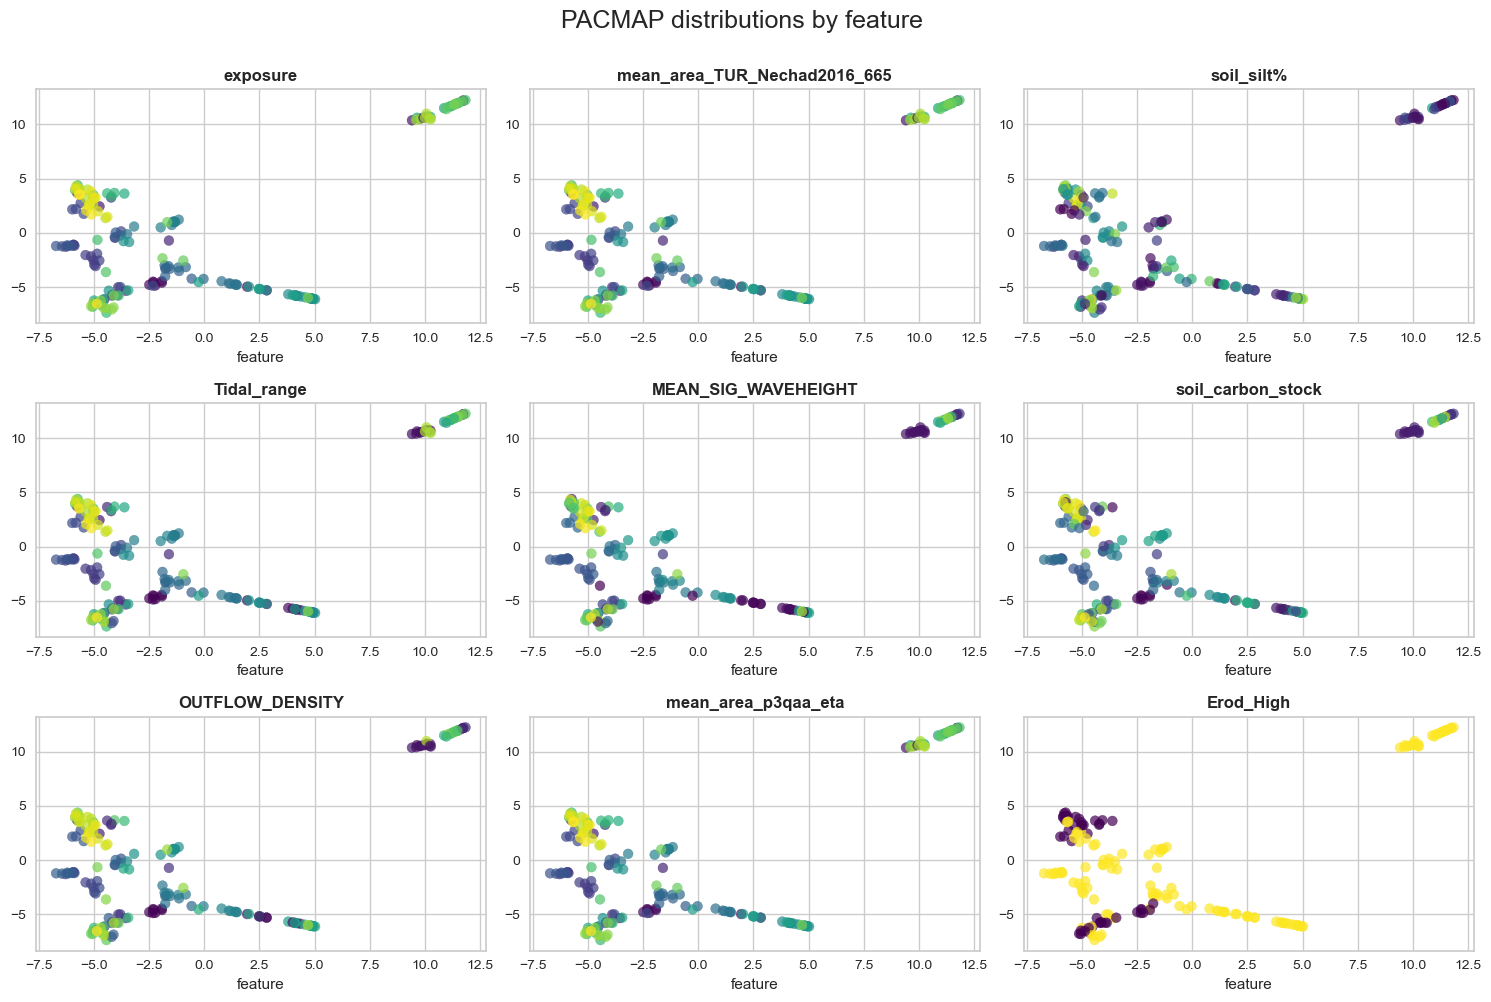

In [91]:
cats = ['exposure', 'mean_area_TUR_Nechad2016_665', 'soil_silt%', 'Tidal_range', 'MEAN_SIG_WAVEHEIGHT', 'soil_carbon_stock', 'OUTFLOW_DENSITY', 'mean_area_p3qaa_eta', 'Erod_High']
X_cats = X_norm.loc[:,cats]

ncols = 3
nrows = len(X_cats.columns)  // ncols + (len(X_cats.columns)  % ncols > 0)
fig = plt.figure(figsize=(15,10))

for n, feature in enumerate(X_cats):
    #print(names[feature])
    ax = plt.subplot(nrows, ncols, n + 1)
    p = plt.scatter(x = X_transformed[:, 0], y = X_transformed[:, 1], cmap="viridis", c=pd.factorize(X_cats[feature])[0], s=50, alpha =0.7)
    ax.set_xlabel('feature')
    ax.set_title(feature,fontweight="bold") 
    #ax.legend()

fig.suptitle('PACMAP distributions by feature', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

## 7. Cluster characteristics

Do PCA on full dataset and then visualise on reduced interpretable dataset?

In [71]:
#select only interpretable features for viz
X = X.loc[:, cluster_cols]
X_norm = X_norm.loc[:, cluster_cols]

#enrich our normalised (X_norm) and non-normalised (X) data with a cluster column.
X['cluster'] = km_fit.labels_
X_norm['cluster'] = km_fit.labels_

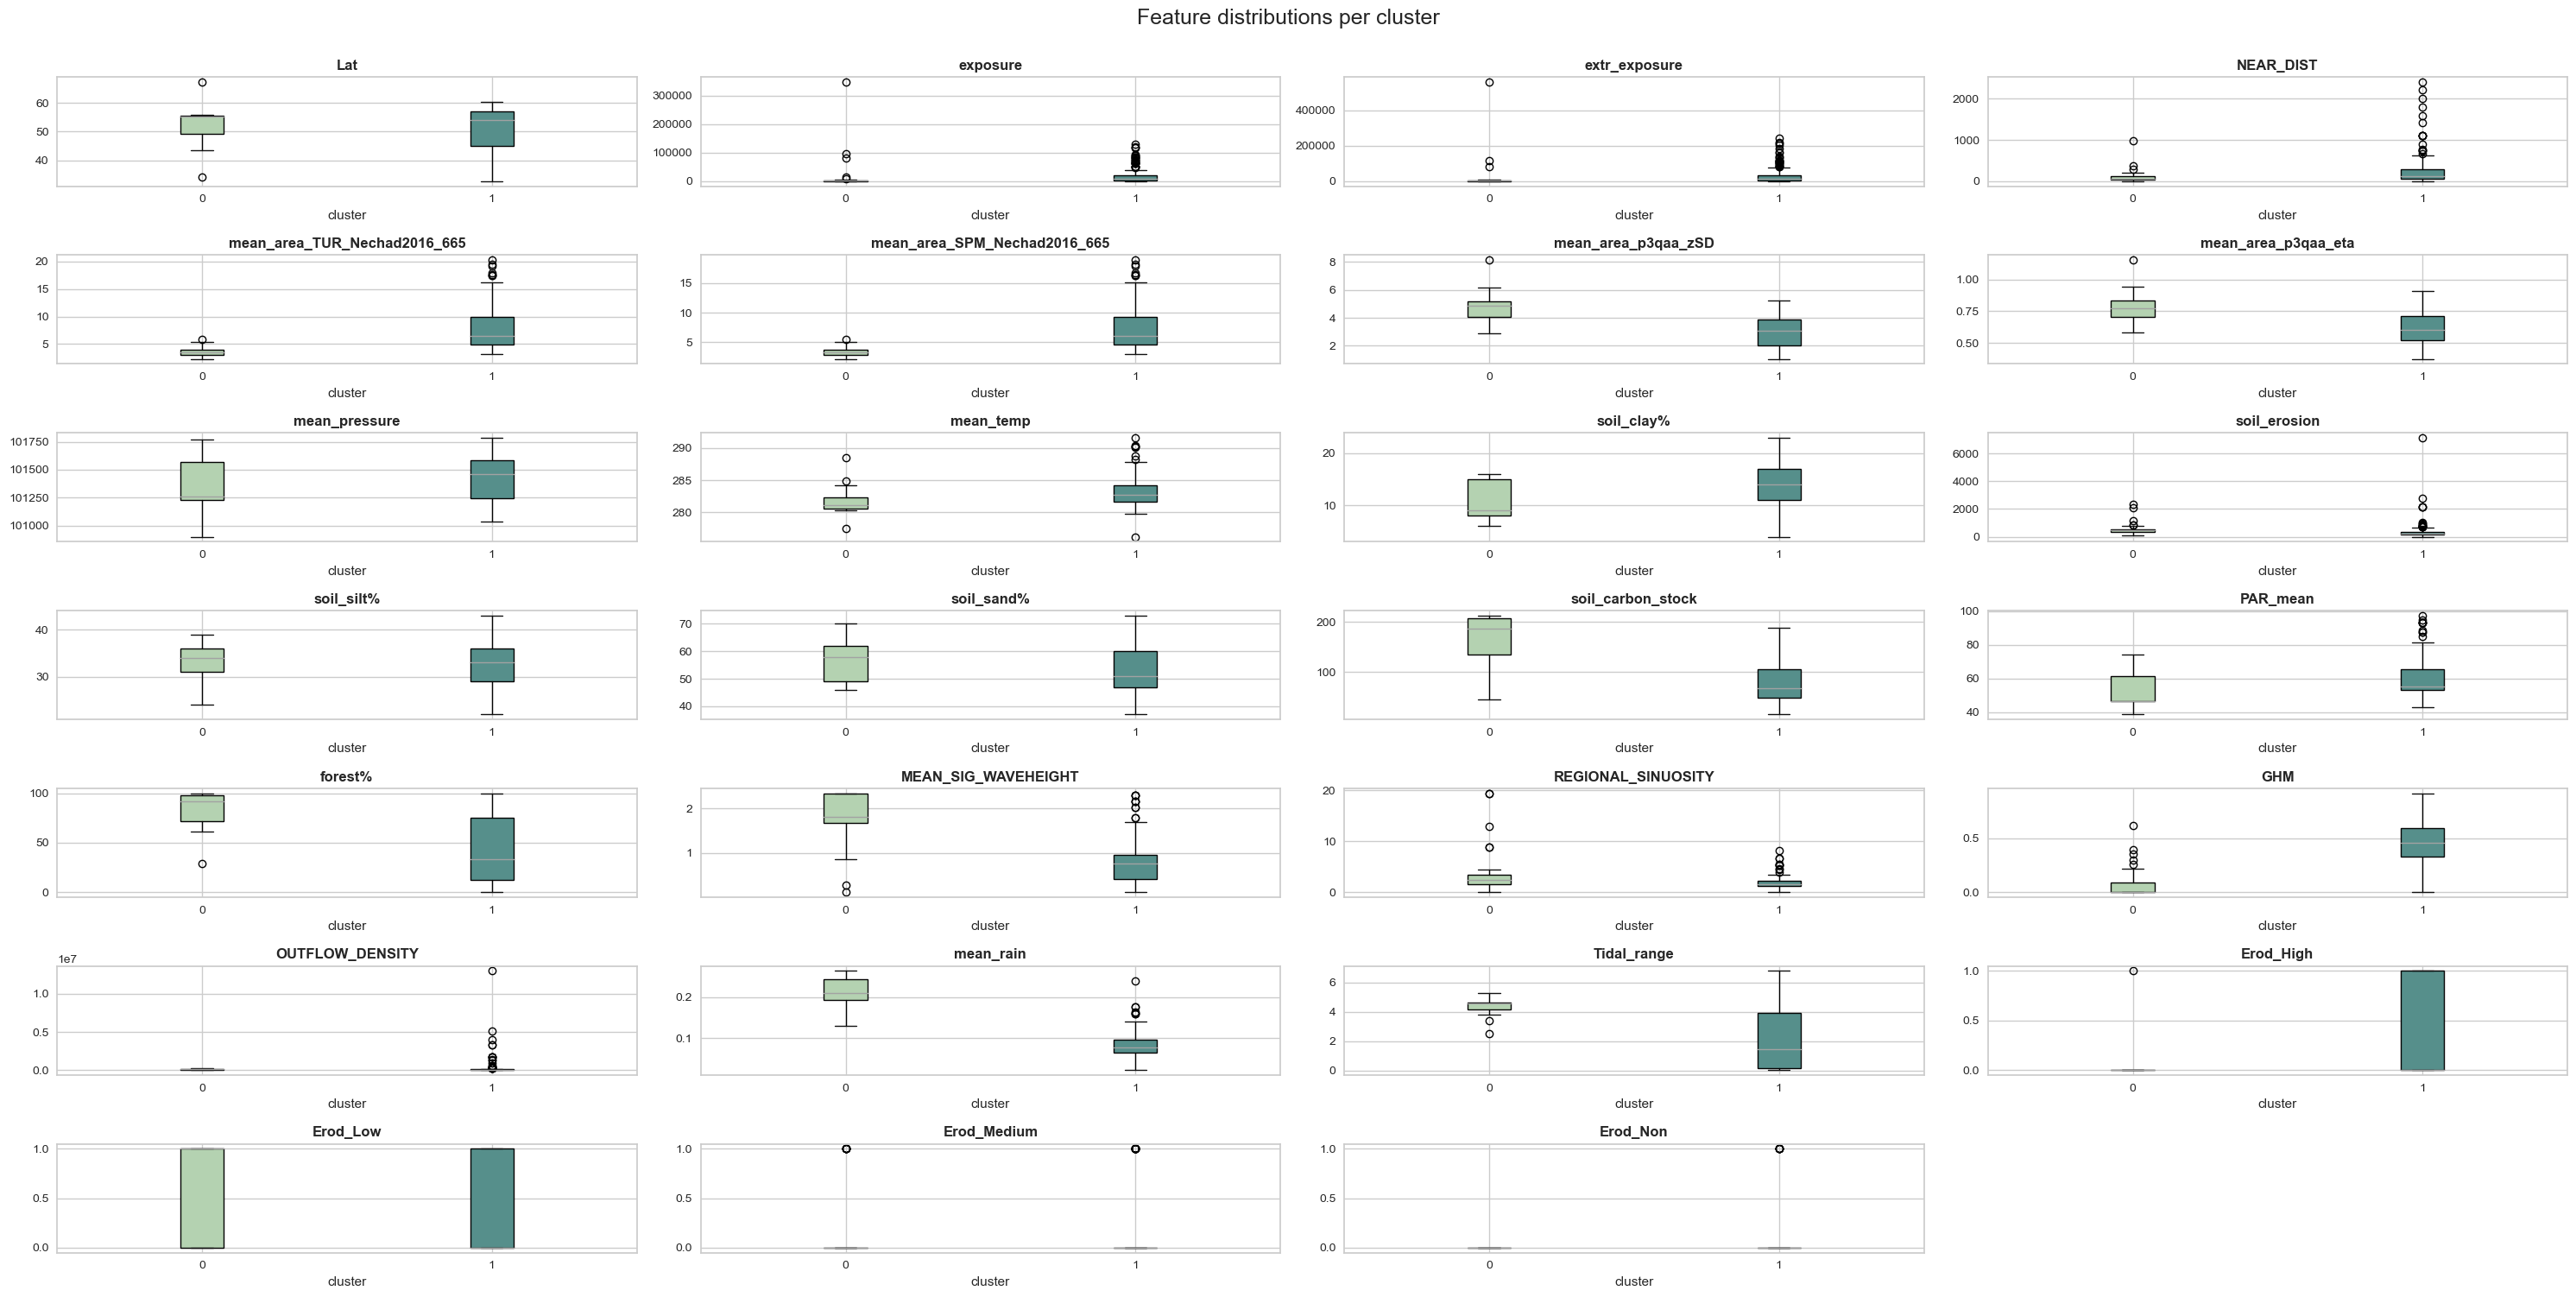

In [72]:
#features = km.feature_names_in_
features = cluster_cols
ncols = 4
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(30,15))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = X[[feature, 'cluster']].boxplot(by='cluster',ax=ax,return_type='both',patch_artist = True)

    for row_key, (ax,row) in box.items():
        ax.set_xlabel('cluster')
        ax.set_title(feature,fontweight="bold")
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

The last 4 plots are from the data I encoded - are these messing up the analysis as they are binary?

### Data preparation

In [73]:
X_mean = pd.concat([pd.DataFrame(X.mean().drop('cluster'), columns=['mean']), 
                   X.groupby('cluster').mean().T], axis=1)

X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_dev_rel.drop(columns=['mean'], inplace=True)
X_mean.drop(columns=['mean'], inplace=True)

In [74]:
X_std_mean = pd.concat([pd.DataFrame(X_norm.mean().drop('cluster'), columns=['mean']), 
                   X_norm.groupby('cluster').mean().T], axis=1)

X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_std_dev_rel.drop(columns=['mean'], inplace=True)
X_std_mean.drop(columns=['mean'], inplace=True)

First, we calculate the mean for each feature per cluster (X_mean, X_std_mean), which is quite similar to the boxplots above.

Second, we calculate the relative differences (in %) of each feature per cluster to the overall average (cluster-independent) per feature (X_dev_rel, X_std_dev_rel). This helps the reader to see how large the differences in each cluster are compared to the overall average of each feature.

Now data is in the right shape - continue with visualisations

### Bar plots

To visualise relative differences we use bar plots - the following plots the differences per cluster for each feature

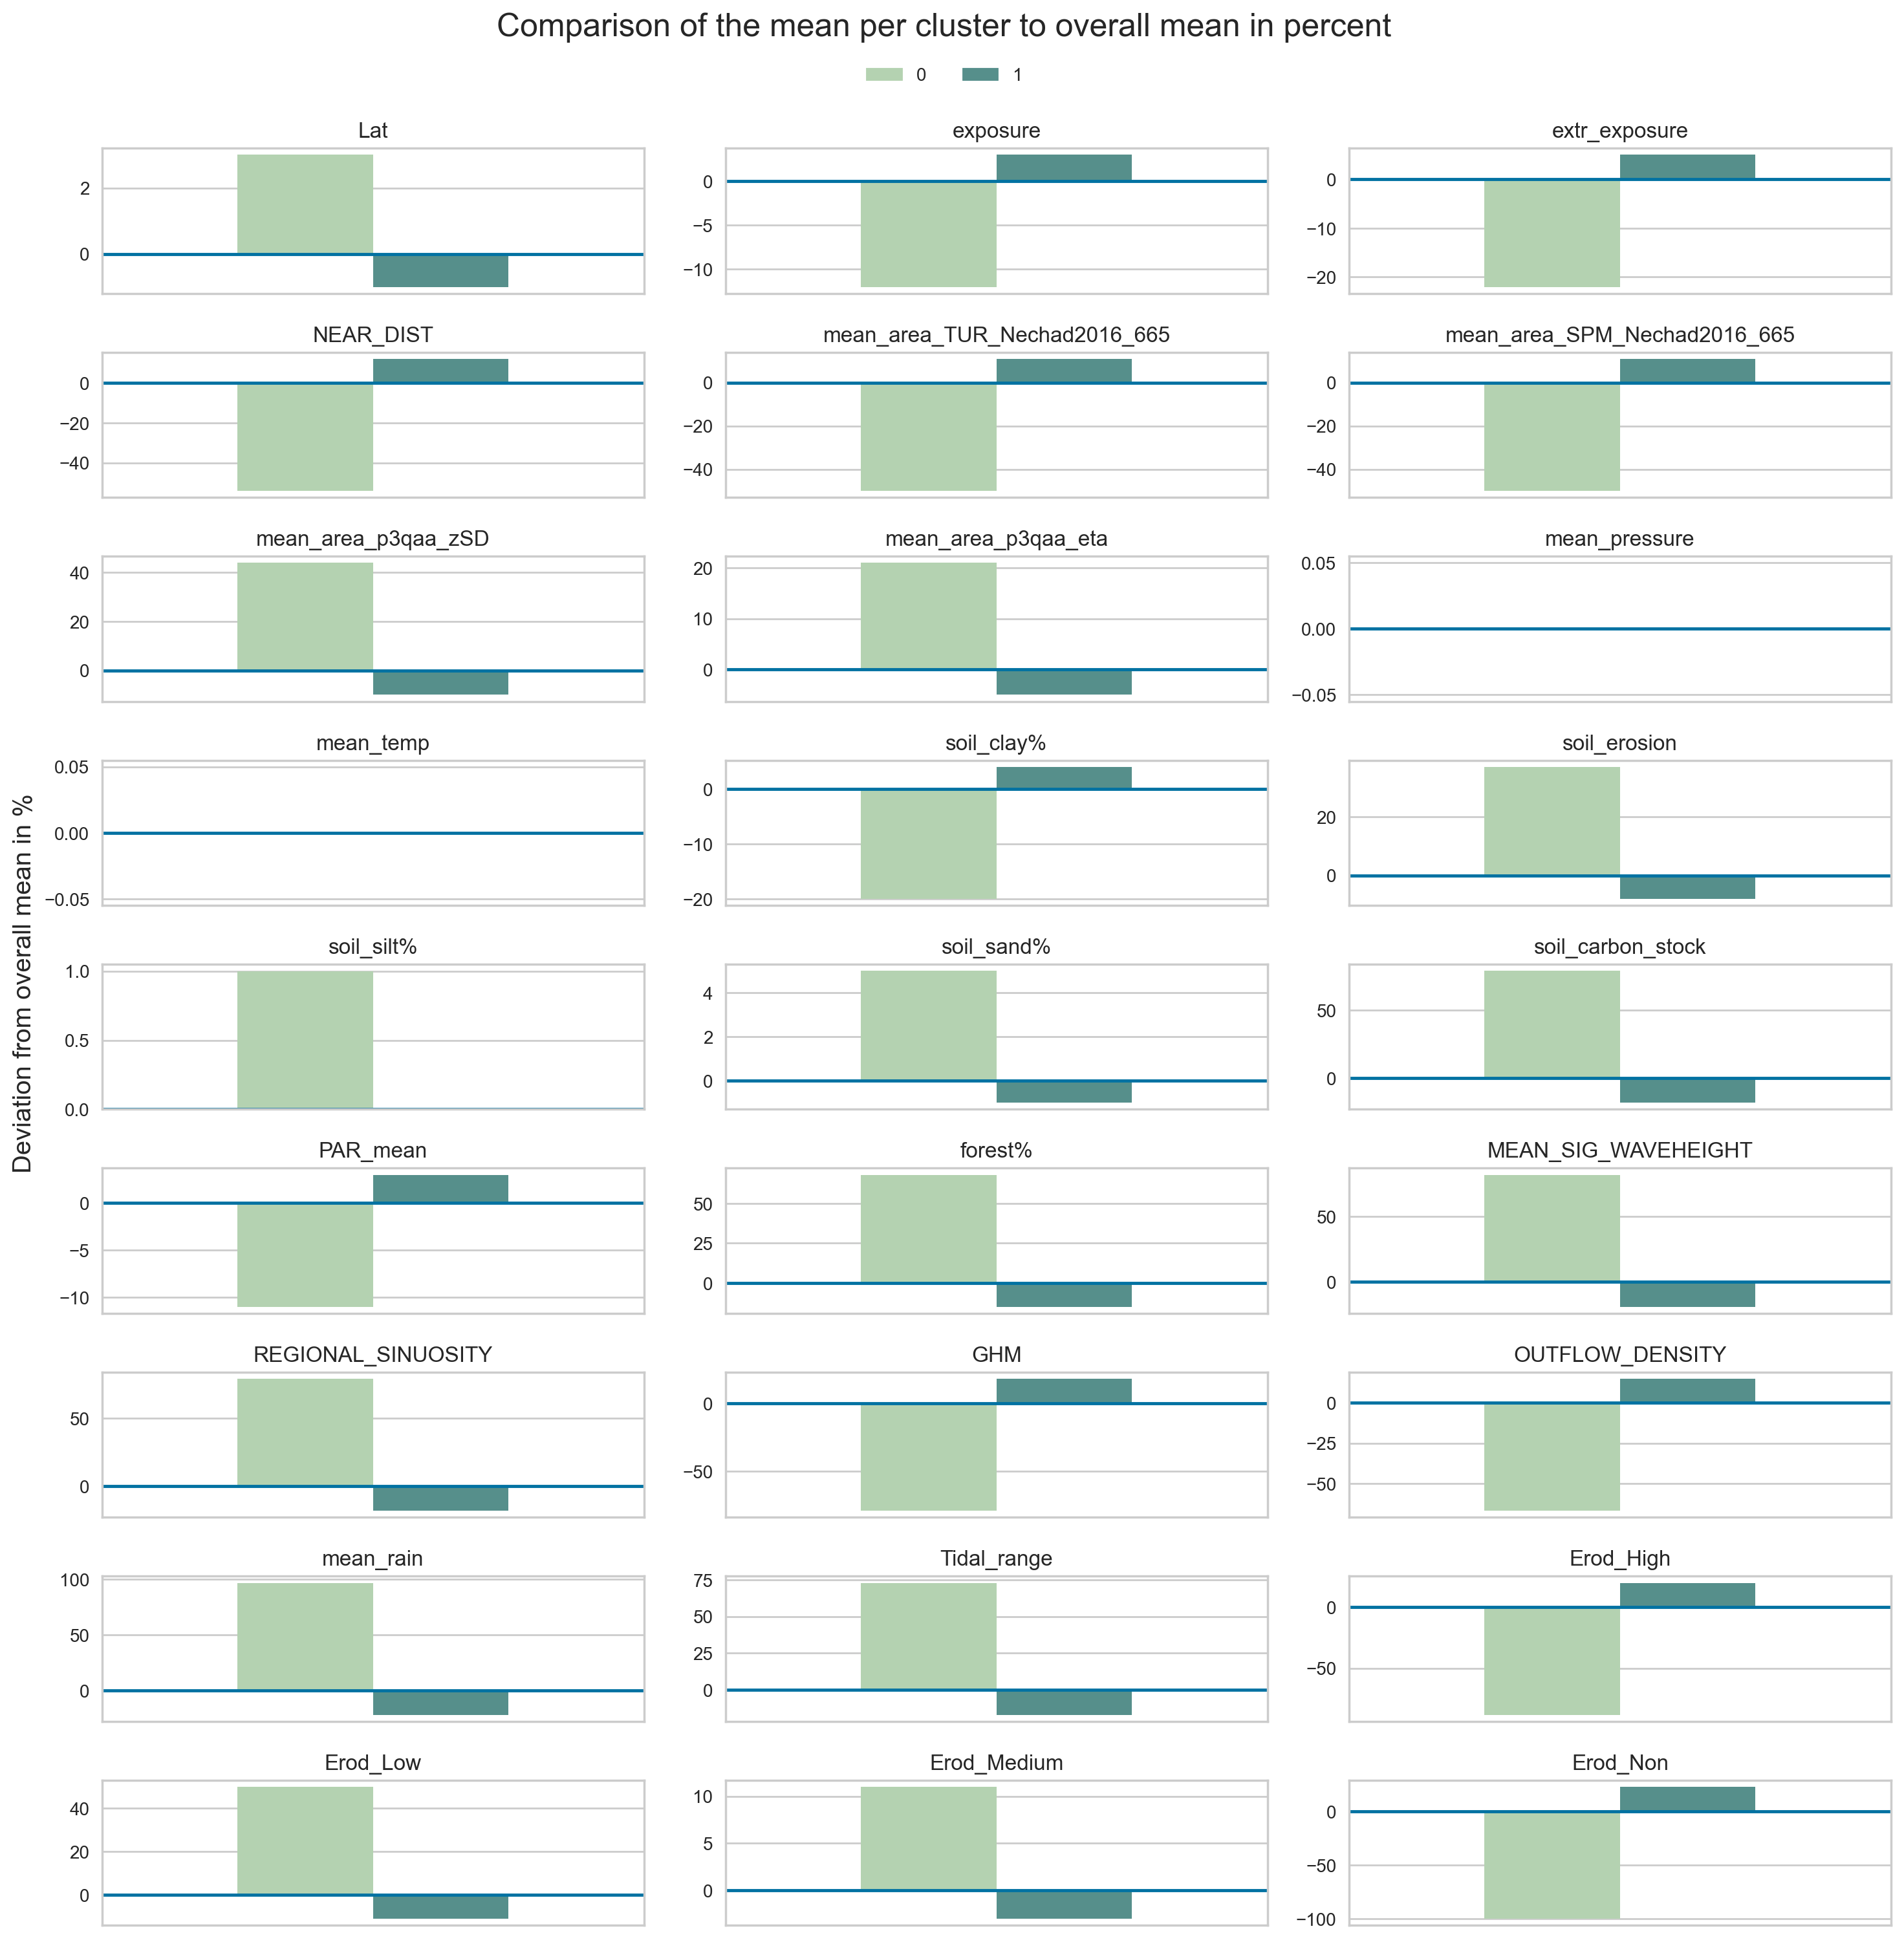

In [75]:
import matplotlib.patches as mpatches
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 3
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:X.cluster.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:X.cluster.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")

These above show the very details of each cluster. 

Now summarise all the relevant results and characteristics in one chart

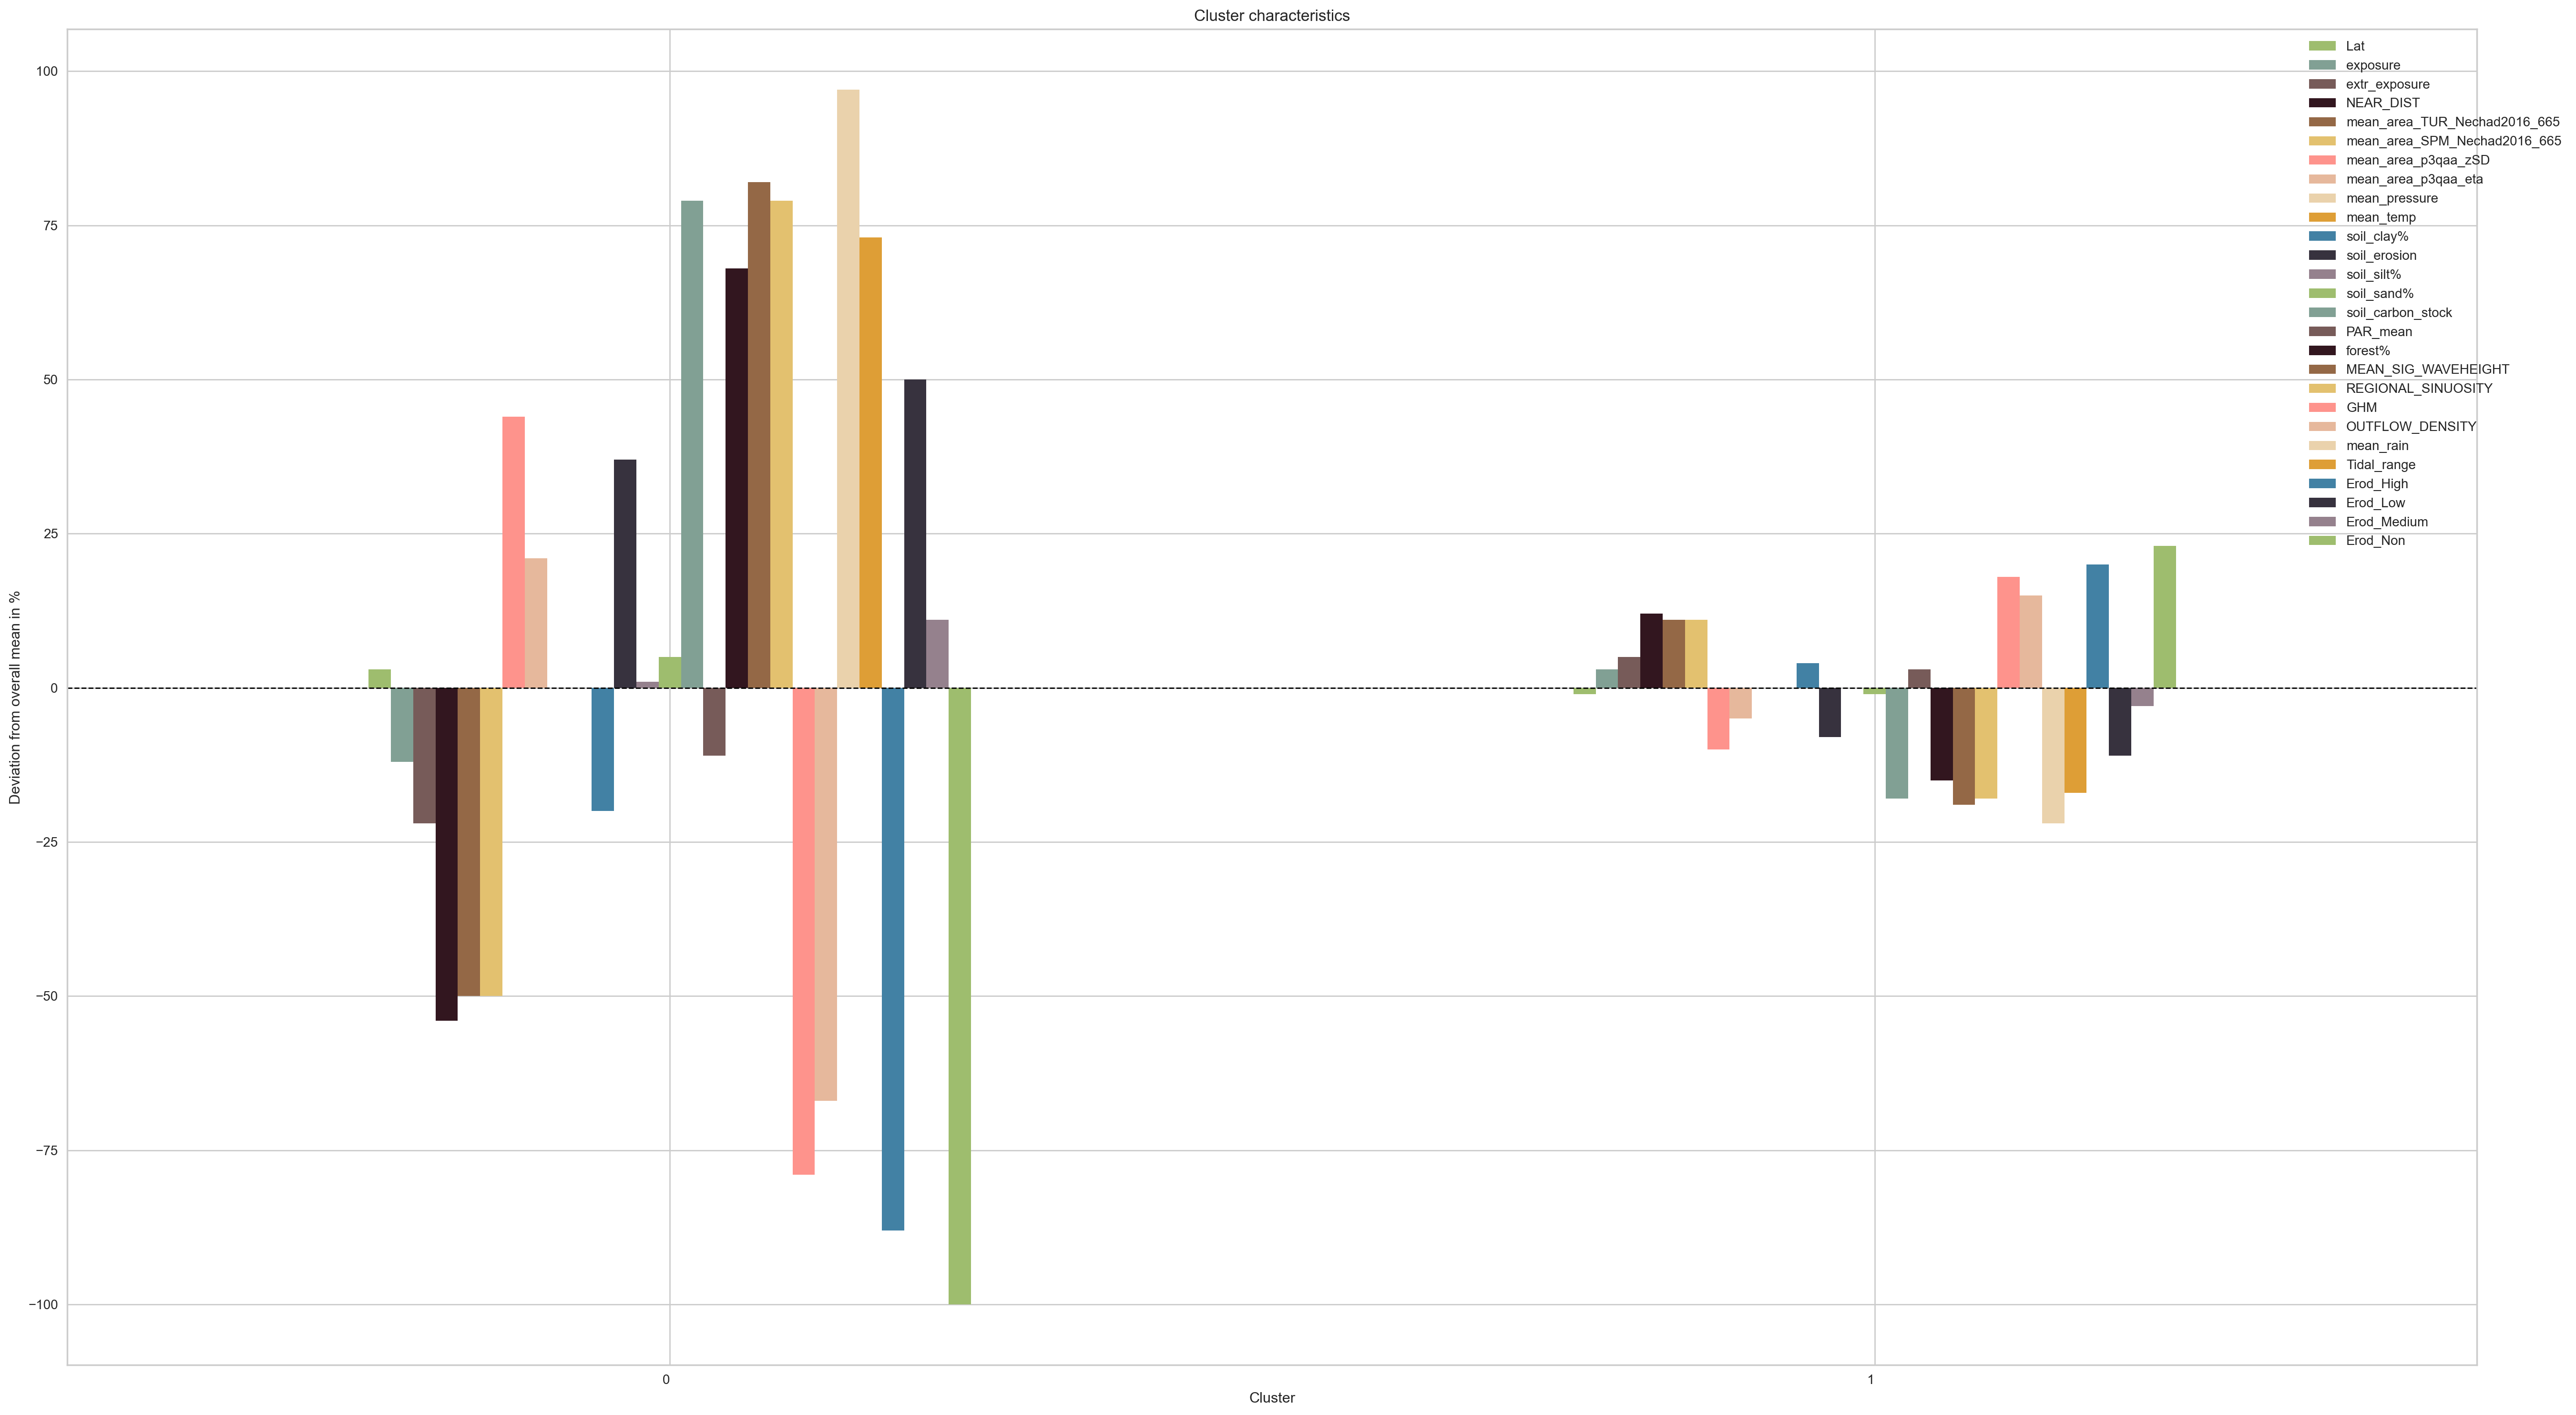

In [76]:
colors = ['#9EBD6E','#81a094','#775b59','#32161f', '#946846', '#E3C16F', '#fe938c', '#E6B89C','#EAD2AC',
          '#DE9E36', '#4281A4','#37323E','#95818D'
         ]

fig = plt.figure(figsize=(30,15), dpi=200)
X_dev_rel.T.plot(kind='bar', 
                       ax=fig.add_subplot(), 
                       title="Cluster characteristics", 
                       color=colors,
                       xlabel="Cluster",
                       ylabel="Deviation from overall mean in %"
                      )
plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(bbox_to_anchor=(1.04,1))
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

The above shows the relative deviation of each feature from its overall average per cluster

Cluster group looks like it has some anomolous data in outflow density??

### Radar chart

The radar chart below plots the calculated means of our normalised data

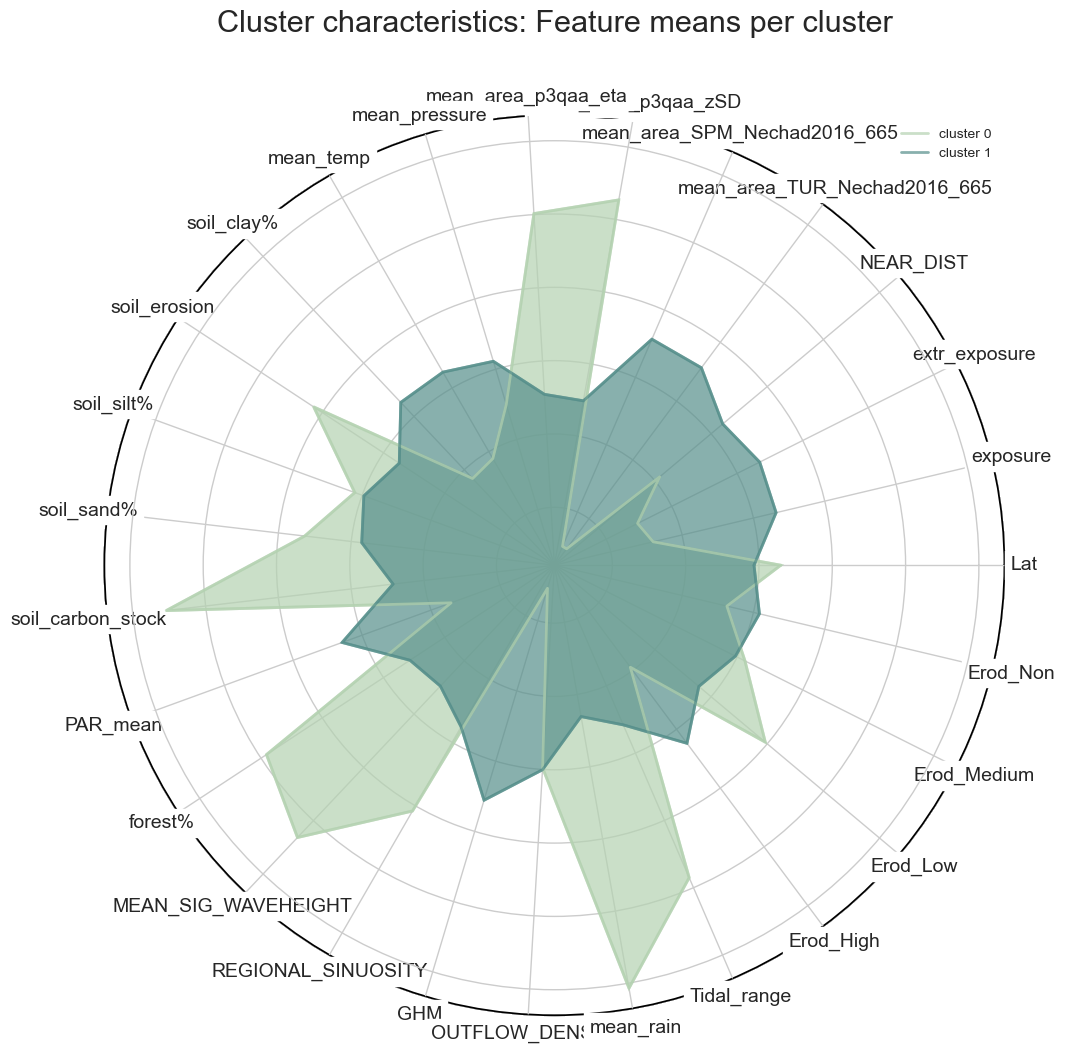

In [78]:
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(10, 10))
#no_features = len(km.feature_names_in_)
no_features = len(cluster_cols)  #replaced with specific columns to plot rather than all
#radar = Radar(fig, km.feature_names_in_, np.unique(km.labels_))
radar = Radar(fig, cluster_cols, np.unique(km.labels_))

for k in range(0,km.n_clusters):
    cluster_data = X_std_mean[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Feature means per cluster", size=22, pad=60)
plt.show()

If use the non-standardised data, the different scales would crash the visualisation - so plot the values with the same unit or at least within similar value ranges

## 8. Cross tabs to understand clusters

In [79]:
#create cross-tab with species
labels = km.labels_
species = names['Species']
df = pd.DataFrame({'labels' : labels, 'species': species})
ct_s = pd.crosstab(df['labels'], df['species'])
ct_s

species,Z. marina,Z. marina mixed
labels,,
0,33,0
1,134,12


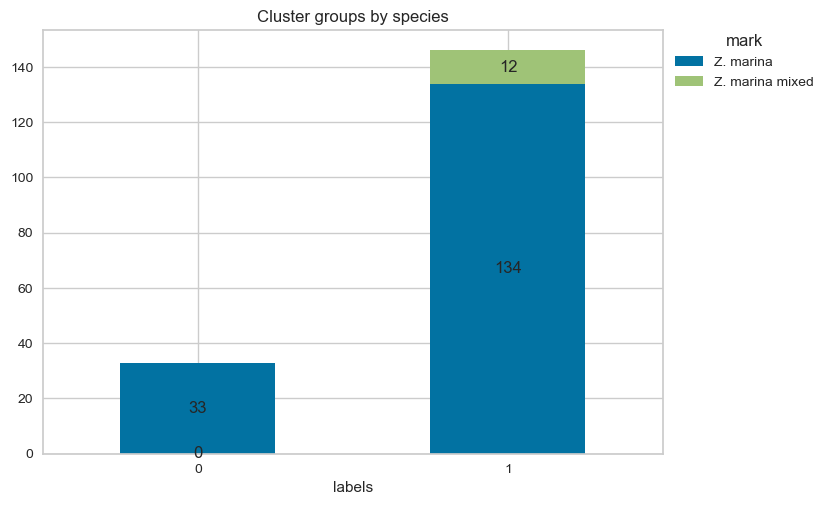

In [80]:
ax = ct_s.plot(kind='bar', stacked=True, rot=0)
ax.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.title('Cluster groups by species')
# add annotations if desired
for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')

In [81]:
#create carbon binned data
df_carbon = names.loc[:, ['Cstock25_Mgha', 'Site_name']]
df_carbon['cstock_log'] = np.log10(df_carbon.Cstock25_Mgha)
bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, np.inf]
cat = ['<0.5', '0.5-1.0', '1.0 - 1.5', '1.5-2.0', '2.0-2.5', '>2.5']
df_carbon['carbon_bin'] = pd.cut(df_carbon['cstock_log'], bins, labels = cat)
#df_carbon
#create cross-tab with carbon
carbon = df_carbon.loc[:,'carbon_bin']
df = pd.DataFrame({'labels' : labels, 'carbon': carbon})
ct_c = pd.crosstab(df['labels'], df['carbon'])
ct_c

carbon,0.5-1.0,1.0 - 1.5,1.5-2.0,2.0-2.5
labels,,,,
0,6,23,4,0
1,37,66,37,2


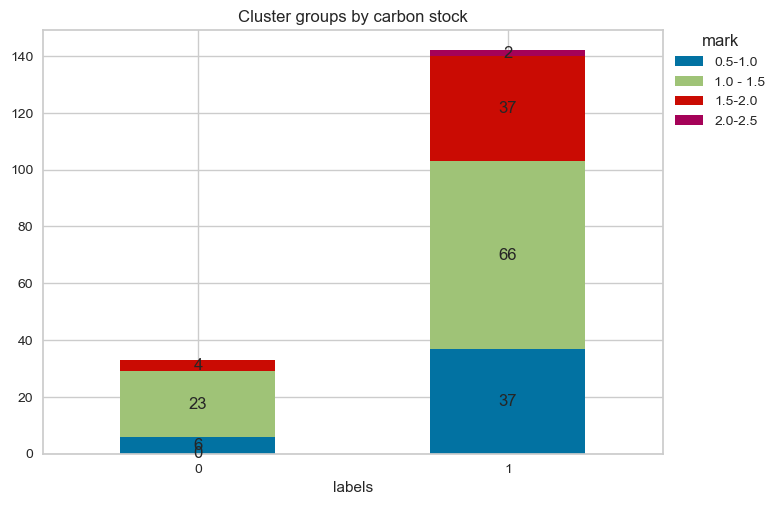

In [82]:
ax = ct_c.plot(kind='bar', stacked=True, rot=0)
ax.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.title('Cluster groups by carbon stock')
# add annotations if desired
for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')

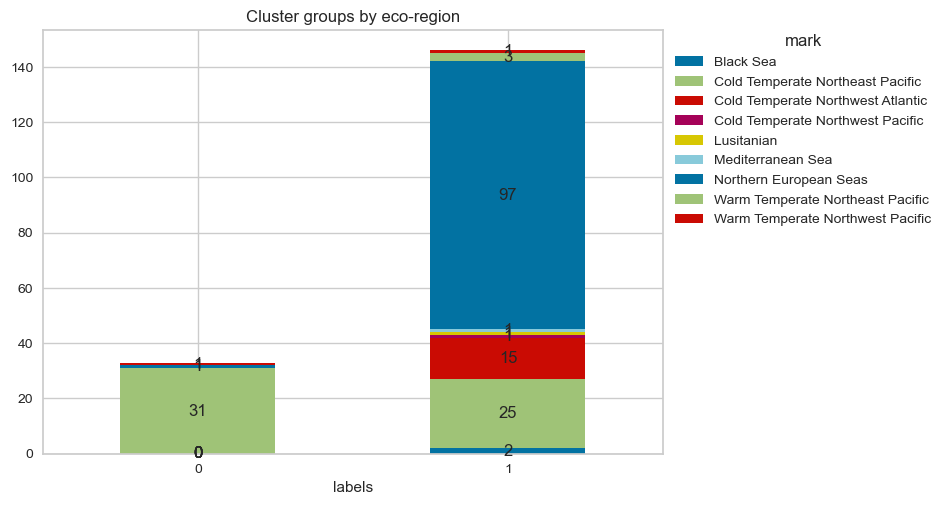

In [83]:
#create cross-tab with ecoregion
region = names['PROVINCE']
df = pd.DataFrame({'labels' : labels, 'region': region})
ct_er = pd.crosstab(df['labels'], df['region'])

ax = ct_er.plot(kind='bar', stacked=True, rot=0)
ax.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.title('Cluster groups by eco-region')
# add annotations if desired
for c in ax.containers:
    
    # set the bar label
    ax.bar_label(c, label_type='center')